In [16]:
import logging
import os
import sys
# import tempfile
from glob import glob

import nibabel as nib
import numpy as np
import torch
from torch.nn.functional import pad
# from ignite.engine import Engine
from torch.utils.data import DataLoader, Dataset

from monai import config
from monai.metrics import DiceMetric
from monai.data import ImageDataset, create_test_image_3d, decollate_batch
from monai.handlers import CheckpointLoader, MeanDice, StatsHandler
from monai.inferers import SimpleInferer
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    # AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    CenterSpatialCrop,
    # RandSpatialCrop,
    # Resize,
    ScaleIntensity,
    EnsureType,
    Transpose,
    SaveImage,
    apply_transform,
)
import matplotlib.pyplot as plt
# import sys
# sys.path.append("/content/drive/MyDrive/unet-with-monai/")
from unet_unit.unet_unit import unit_model
from ignite.handlers import Checkpoint

# os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [17]:
print(torch.cuda.is_available())

print(torch.cuda.device_count())

print(torch.cuda.get_device_name(0))

print(torch.cuda.current_device())

True
4
GeForce GTX 1080
0


Feature batch shape: torch.Size([1, 1, 640, 640])
Labels batch shape: torch.Size([1, 1, 640, 640])


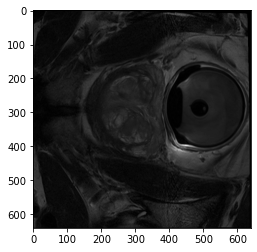

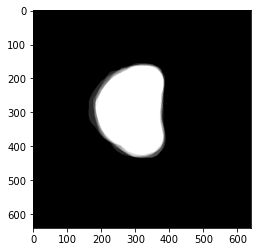

In [19]:
# config.print_config()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

try:
    os.mkdir('exp_new')
except:
    pass
root_dir = "./exp_new"
data_dir = "./dataset/prostate"
test_dir = os.path.join(data_dir, 'Test')

images_test = sorted(glob(os.path.join(test_dir, "case*_image.nii.gz")))
segs_test = [sorted(glob(os.path.join(test_dir, f"case*_task01_seg{i:02d}.nii.gz"))) for i in range(1, 7)]

imtrans_test = Compose(
    [
        # LoadImage(image_only=True),
        ScaleIntensity(),
        Transpose((2, 0, 1)),
        # AddChannel(),
        # CenterSpatialCrop((640, 640)),
        # RandSpatialCrop((96, 96), random_size=False),
        EnsureType(),
    ]
)
segtrans_test = Compose(
    [
        # LoadImage(image_only=True),
        Transpose((2, 0, 1)),
        # AddChannel(),
        # CenterSpatialCrop((640, 640)),
        # RandSpatialCrop((96, 96), random_size=False),
        EnsureType(),
    ]
)



class evaluator_Dataset(Dataset):
    def __init__(self, img_list, seg_origin_list, img_transform=None, seg_transform=None):
        self.loader = LoadImage()
        self.img_list, self.img_metadata_list = [self.loader(img_list[i])[0] for i in range(len(img_list))], [self.loader(img_list[i])[1] for i in range(len(img_list))]
        self.seg_origin_list, self.seg_origin_metadata_list = [[self.loader(seg_origin_list[j][i])[0] for i in range(len(img_list))] for j in range(6)], [[self.loader(seg_origin_list[j][i])[1] for i in range(len(img_list))] for j in range(6)]

        self.img_list = apply_transform(img_transform, self.img_list, map_items=False)
        #self.img_metadata_list = [apply_transform(img_transform, self.img_metadata_list[i], map_items=False, unpack_items=True) for i in range(len(img_list))]
        self.seg_origin_list = [apply_transform(seg_transform, self.seg_origin_list[i], map_items=False) for i in range(6)]

        self.seg_merged_list = self.seg_origin_list[0]
        for i in range(len(self.seg_merged_list)):
            for j in range(1, 6):
                self.seg_merged_list[i] += self.seg_origin_list[j][i]
            self.seg_merged_list[i].div_(6)
        self.seg_merged_metadata_list = self.seg_origin_metadata_list[0]
        # for i in range(len(self.img_metadata_list)):
        #     print(type(self.img_metadata_list[i]))


        if len(self.img_list) != len(self.seg_merged_list):
            raise ValueError(
                "Must have same the number of segmentation as image files: "
                f"images={len(self.img_list)}, segmentations={len(self.seg_merged_list)}."
            )

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        return self.img_list[idx], self.seg_merged_list[idx], self.img_metadata_list[idx], self.seg_merged_metadata_list[idx]


dataset_test = evaluator_Dataset(images_test, segs_test, imtrans_test, segtrans_test)
loader_test = DataLoader(dataset_test, batch_size=1, num_workers=4, pin_memory=torch.cuda.is_available())

train_features, train_labels, c, d = next(iter(loader_test))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0].squeeze()
plt.imshow(img, cmap="gray")
plt.show()
plt.imshow(label, cmap="gray")
plt.show()

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = [UNet(
    dimensions=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device) for i in range(6)]

In [21]:
pretrained = True
for id in range(1, 7):
    if not pretrained:
        unit_model(id, device)
    check_point_path = glob(os.path.join(root_dir, f"./logs_{id:02d}", "*.pt"))
    if len(check_point_path) > 1:
      raise ValueError
    check_point_path = check_point_path[0]
    Checkpoint.load_objects(to_load={"net": model[id-1]}, checkpoint=torch.load(check_point_path))

In [22]:
post_trans_avgd_out = [Compose([EnsureType(), AsDiscrete(threshold_values=True, logit_thresh=i)]) for i in (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9)]

post_trans_single_out = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold_values=True)])

dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)


saver = SaveImage(os.path.join(root_dir, 'output'), output_ext=".nii.gz", output_postfix="seg")

cut = False
cut_trans = Compose([CenterSpatialCrop((1, 640, 640)), EnsureType()])
save_pred = True


for i in range(6):
    model[i].eval()
with torch.no_grad():
    for item in loader_test:
        img, seg = item[0].to(device), item[1].to(device)
        if img.shape[2] != 640:
            img = cut_trans(img)
            cut = True
            # define sliding window size and batch size for windows inference
            # roi_size = (640, 640)
            # sw_batch_size = 2
        output = post_trans_single_out(model[0](img))
        
        for i in range(1, 6):
            output += post_trans_single_out(model[i](img))
        output.div_(6)
        if cut:
            output = pad(output, (0, 0, 160, 160), "constant", 0)
            cut = False

        merget_output = []
        merged_seg = []
        for i, j in zip(decollate_batch(output), decollate_batch(seg)):
            for threshold in range(9):
                merget_output.append(post_trans_avgd_out[threshold](i))
                merged_seg.append(post_trans_avgd_out[threshold](j))
        meta_data = decollate_batch(item[2])
        # compute metric for current iteration
        dice_metric(y_pred=merget_output, y=merged_seg)
        if save_pred:
            for val_output, data in zip(output, meta_data):
                saver(val_output, data)
    # aggregate the final mean dice result
    print("evaluation metric:", dice_metric.aggregate().item())
    # reset the status
    dice_metric.reset()

file written: /root/src/unet-with-monai/exp_new/output/case46_image/case46_image_seg.nii.gz.
file written: /root/src/unet-with-monai/exp_new/output/case47_image/case47_image_seg.nii.gz.
file written: /root/src/unet-with-monai/exp_new/output/case48_image/case48_image_seg.nii.gz.
file written: /root/src/unet-with-monai/exp_new/output/case49_image/case49_image_seg.nii.gz.
file written: /root/src/unet-with-monai/exp_new/output/case50_image/case50_image_seg.nii.gz.
file written: /root/src/unet-with-monai/exp_new/output/case51_image/case51_image_seg.nii.gz.
file written: /root/src/unet-with-monai/exp_new/output/case52_image/case52_image_seg.nii.gz.
file written: /root/src/unet-with-monai/exp_new/output/case53_image/case53_image_seg.nii.gz.
file written: /root/src/unet-with-monai/exp_new/output/case54_image/case54_image_seg.nii.gz.
evaluation metric: 0.8384337425231934
